In [ ]:
import torch
print(torch.__version__)
print("GPU available:", torch.cuda.is_available())

2.6.0+cu124
GPU available: True


Import Libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
!pip install piq
!pip install torchmetrics
from piq import ssim, ms_ssim, psnr
from torchmetrics import (
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure,
    MeanSquaredError,
    MultiScaleStructuralSimilarityIndexMeasure,
)
from torch.utils.data import DataLoader

CelebA dataset

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

# Load dataset
train_data = datasets.CelebA(
    root="./data", split="train", download=True, transform=transform
)
test_data = datasets.CelebA(
    root="./data", split="test", download=True, transform=transform
)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

CIFAR-10-HR Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Loss Functions

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mse_metric = MeanSquaredError().to(device)
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def mse_loss(output, target):
    return mse_metric(output, target)

def psnr_loss(output, target):
    return 1 - psnr_metric(output, target)

def ssim_loss(output, target):
    return 1 - ssim_metric(output, target)

def ms_ssim_loss(output, target):
    return 1 - ms_ssim_metric(output, target)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Basic Autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

Latent Quantizer Function

In [11]:
def quantize(tensor, levels=16):
    min_val = tensor.min()
    max_val = tensor.max()
    scale = (max_val - min_val) / (levels - 1)
    return torch.round((tensor - min_val) / scale) * scale + min_val

Quantized Autoencoder

In [12]:
class AutoencoderQuantized(nn.Module):
    def __init__(self):
        super(AutoencoderQuantized, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        quantized = quantize(latent, levels=16)
        reconstructed = self.decoder(quantized)
        return reconstructed


Model, Loss & Optimizer Definition

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train Function

In [14]:
def train_model(model, loss_fn, optimizer, num_epochs=10, loss_name="Loss", save_path="autoencoder.pth"):
    model.train()
    for epoch in range(num_epochs):
        for data in train_loader:
            imgs, _ = data
            imgs = imgs.to(device)

            outputs = model(imgs)
            loss = loss_fn(outputs, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], {loss_name}: {loss.item():.4f}")

        # Save model after each epoch
        torch.save(model.state_dict(), save_path)
        print(f"Model weights saved to {save_path}")
        print("\n")
    print("-----------------------------------------------")

Test & Visualize Function

In [15]:

def test_and_visualize_model(model, weight_path="autoencoder.pth", title="Reconstructed"):
    # Load model and send to device
    model.load_state_dict(torch.load(weight_path))
    model.to(device)
    model.eval()

    # Define metrics and send to device
    mse_metric = MeanSquaredError().to(device)
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure().to(device)
    ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for data in test_loader:
            imgs, _ = data
            imgs = imgs.to(device)

            outputs = model(imgs)

            # Calculate values for each metric
            mse_val = mse_metric(outputs, imgs).item()
            psnr_val = psnr_metric(outputs, imgs).item()
            ssim_val = ssim_metric(outputs, imgs).item()
            ms_ssim_val = ms_ssim_metric(outputs, imgs).item()

            print(f"MSE: {mse_val:.6f}")
            print(f"PSNR: {psnr_val:.4f}")
            print(f"SSIM: {ssim_val:.4f}")
            print(f"MS-SSIM: {ms_ssim_val:.4f}")

            # Move images to CPU
            imgs = imgs.cpu()
            outputs = outputs.cpu()

            # Visualization
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            for i in range(8):
                axes[0][i].imshow(imgs[i].permute(1, 2, 0))
                axes[0][i].set_title("Original")
                axes[0][i].axis('off')

                axes[1][i].imshow(outputs[i].permute(1, 2, 0))
                axes[1][i].set_title(
                    f"{title}\nMSE: {mse_val:.4f}\nPSNR: {psnr_val:.2f}\nSSIM: {ssim_val:.2f}\nMS-SSIM: {ms_ssim_val:.2f}"
                )
                axes[1][i].axis('off')

            plt.tight_layout()
            plt.show()
            break  # sadece ilk batch için test


Training with Autoencoder

In [16]:
# Start Autoencoder
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training: MSE Loss
train_model(model, mse_loss, optimizer, num_epochs=10, loss_name="MSE Loss", save_path="autoencoder_mse.pth")

# Training: PSNR Loss
train_model(model, psnr_loss, optimizer, num_epochs=10, loss_name="PSNR Loss", save_path="autoencoder_psnr.pth")




Epoch [1/10], MSE Loss: 0.0004
Model weights saved to autoencoder_mse.pth


Epoch [2/10], MSE Loss: 0.0003
Model weights saved to autoencoder_mse.pth


Epoch [3/10], MSE Loss: 0.0003
Model weights saved to autoencoder_mse.pth


Epoch [4/10], MSE Loss: 0.0002
Model weights saved to autoencoder_mse.pth


Epoch [5/10], MSE Loss: 0.0007
Model weights saved to autoencoder_mse.pth


Epoch [6/10], MSE Loss: 0.0001
Model weights saved to autoencoder_mse.pth


Epoch [7/10], MSE Loss: 0.0002
Model weights saved to autoencoder_mse.pth


Epoch [8/10], MSE Loss: 0.0001
Model weights saved to autoencoder_mse.pth


Epoch [9/10], MSE Loss: 0.0001
Model weights saved to autoencoder_mse.pth


Epoch [10/10], MSE Loss: 0.0001
Model weights saved to autoencoder_mse.pth


-----------------------------------------------
Epoch [1/10], PSNR Loss: -37.0819
Model weights saved to autoencoder_psnr.pth


Epoch [2/10], PSNR Loss: -40.2305
Model weights saved to autoencoder_psnr.pth


Epoch [3/10], PSNR Loss: -42.22

Training with Quantized Autoencoder

In [17]:
# Start AutoencoderQuantized
model1 = AutoencoderQuantized().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)

# Training: SSIM Loss
train_model(model1, ssim_loss, optimizer1, num_epochs=10, loss_name="SSIM Loss", save_path="autoencoder_ssim_quantized.pth")





Epoch [1/10], SSIM Loss: 0.1149
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [2/10], SSIM Loss: 0.1003
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [3/10], SSIM Loss: 0.0976
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [4/10], SSIM Loss: 0.1024
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [5/10], SSIM Loss: 0.0869
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [6/10], SSIM Loss: 0.0930
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [7/10], SSIM Loss: 0.0990
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [8/10], SSIM Loss: 0.0887
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [9/10], SSIM Loss: 0.1031
Model weights saved to autoencoder_ssim_quantized.pth


Epoch [10/10], SSIM Loss: 0.0990
Model weights saved to autoencoder_ssim_quantized.pth


-----------------------------------------------


In [18]:
# Start AutoencoderQuantized
model1 = AutoencoderQuantized().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)



# Training: MS-SSIM Loss
train_model(model1, ms_ssim_loss, optimizer1, num_epochs=10, loss_name="MS-SSIM Loss", save_path="autoencoder_ms_ssim_quantized.pth")




Epoch [1/10], MS-SSIM Loss: 0.0638
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [2/10], MS-SSIM Loss: 0.0581
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [3/10], MS-SSIM Loss: 0.0700
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [4/10], MS-SSIM Loss: 0.0525
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [5/10], MS-SSIM Loss: 0.0769
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [6/10], MS-SSIM Loss: 0.0500
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [7/10], MS-SSIM Loss: 0.0779
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [8/10], MS-SSIM Loss: 0.0767
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [9/10], MS-SSIM Loss: 0.0599
Model weights saved to autoencoder_ms_ssim_quantized.pth


Epoch [10/10], MS-SSIM Loss: 0.0673
Model weights saved to autoencoder_ms_ssim_quantized.pth


-----------------------------------------------


Test & Visualize

MSE: 0.000119
PSNR: 39.2566
SSIM: 0.9676
MS-SSIM: 0.9959


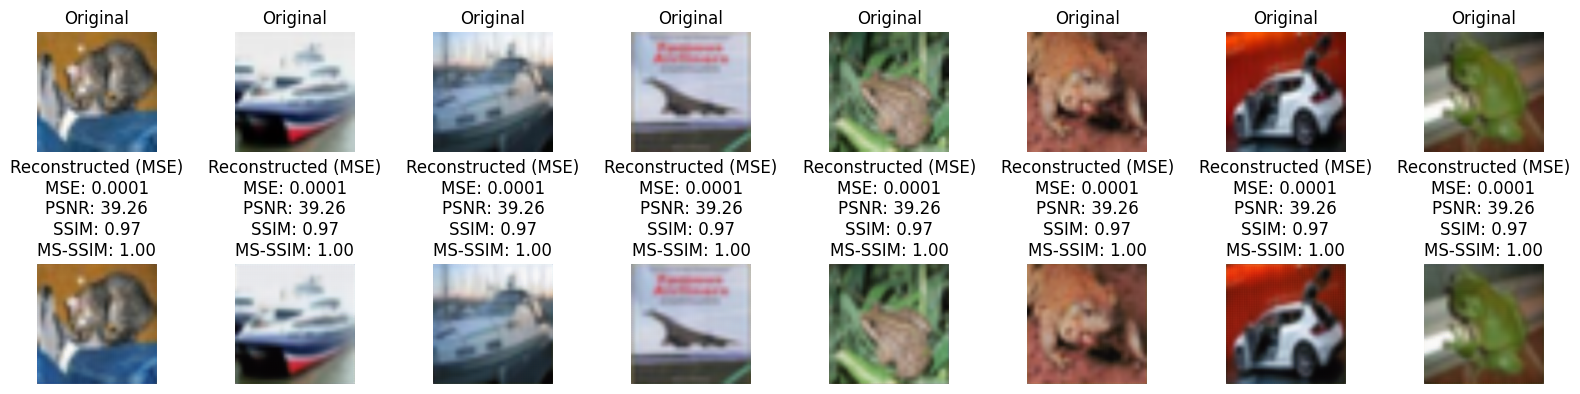

MSE: 0.000038
PSNR: 44.2330
SSIM: 0.9869
MS-SSIM: 0.9985


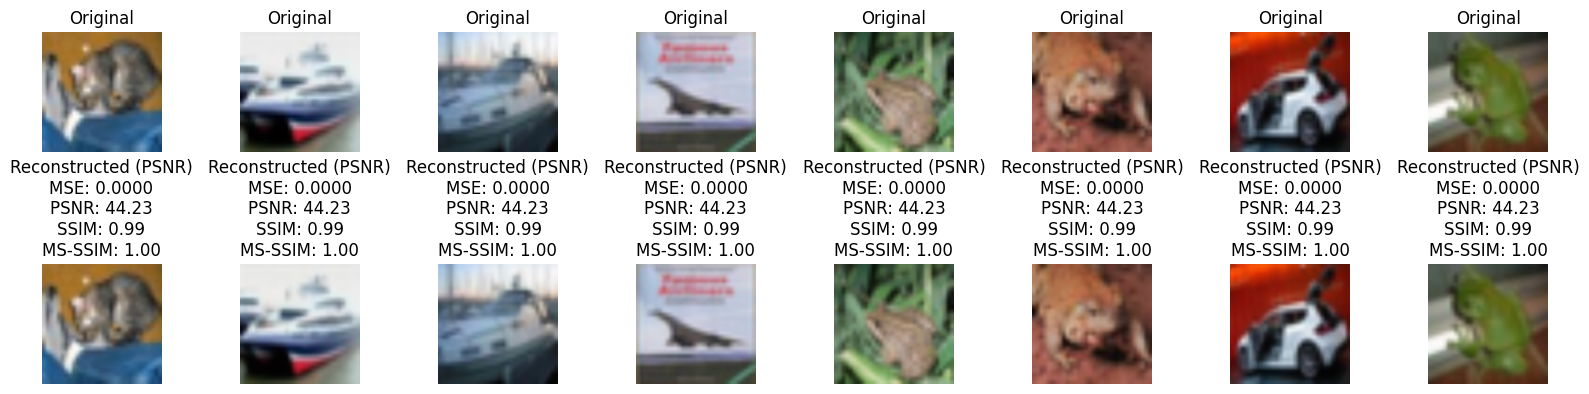

MSE: 0.022278
PSNR: 16.5213
SSIM: 0.8073
MS-SSIM: 0.9002


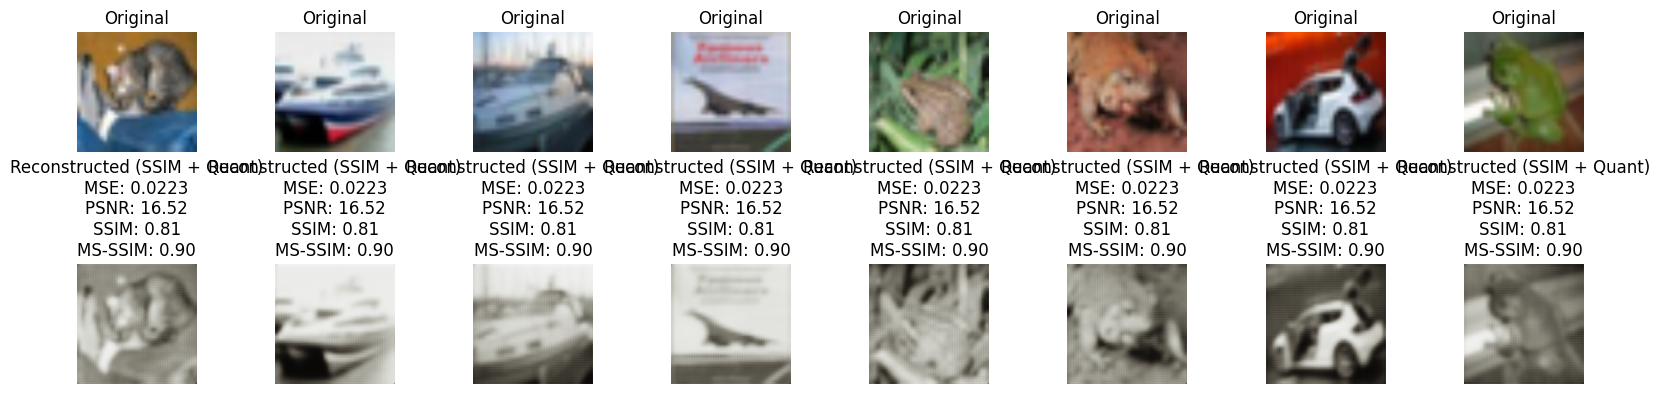

MSE: 0.013002
PSNR: 18.8600
SSIM: 0.8338
MS-SSIM: 0.9230


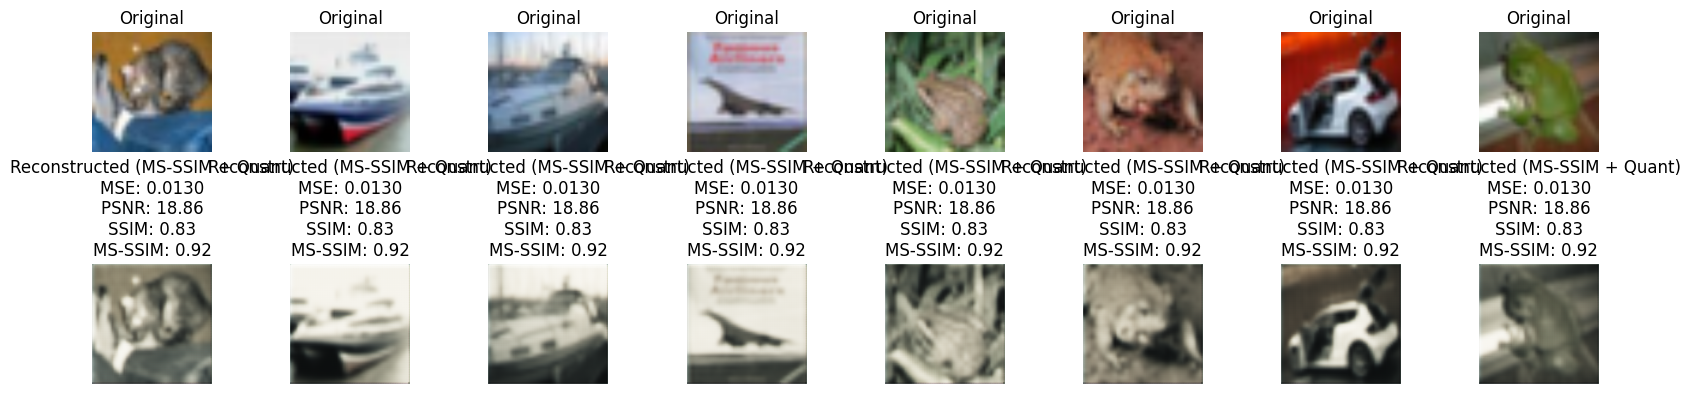

In [19]:
test_and_visualize_model(model, weight_path="autoencoder_mse.pth", title="Reconstructed (MSE)")
test_and_visualize_model(model, weight_path="autoencoder_psnr.pth", title="Reconstructed (PSNR)")
test_and_visualize_model(model, weight_path="autoencoder_ssim_quantized.pth", title="Reconstructed (SSIM + Quant)")
test_and_visualize_model(model, weight_path="autoencoder_ms_ssim_quantized.pth", title="Reconstructed (MS-SSIM + Quant)")